# Load tools

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
#%pip install "pytorch==1.10.1"
%pip install transformers datasets tensorboard --upgrade

!sudo apt-get install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Preprocess & load dataset

In [ ]:
from datasets import load_metric
import numpy as np
from transformers import AutoTokenizer

tokenizer_id = "google/bert_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)

def process(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, max_length=512
    )
    return tokenized_inputs

# define metrics and metrics function
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {
        "accuracy": acc["accuracy"],
    }

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

<ipython-input-4-3ae511a5faa6>:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

def create_dataset(dataset_id, dataset_config, tokenizer_id):
  dataset = load_dataset(dataset_id,dataset_config)
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  tokenized_datasets = dataset.map(process, batched=True)
  tokenized_datasets = tokenized_datasets.rename_column("label","labels")
  tokenized_datasets["test"].features
  labels = tokenized_datasets["train"].features["labels"].names

  num_labels = len(labels)
  label2id, id2label = dict(), dict()
  for i, label in enumerate(labels):
      label2id[label] = str(i)
      id2label[str(i)] = label

  return num_labels, label2id, id2label, tokenized_datasets, data_collator

In [ ]:
dataset_id="glue"
dataset_config="sst2"
tokenizer_id = "google/bert_uncased_L-12_H-768_A-12" # Base-BERT

num_labels, label2id, id2label, tokenized_datasets, data_collator = create_dataset(dataset_id, dataset_config, tokenizer_id)

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

# Define Distillation tools

### One-Step Straightforward Distillation


In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        # place teacher on same device as student
        self._move_model_to_device(self.teacher,self.model.device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):

        # compute student output
        outputs_student = model(**inputs)
        student_loss=outputs_student.loss
        # compute teacher output
        with torch.no_grad():
          outputs_teacher = self.teacher(**inputs)

        # assert size
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Soften probabilities and compute distillation loss
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))
        # Return weighted student loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
        return (loss, outputs_student) if return_outputs else loss

In [ ]:
from transformers import AutoModelForSequenceClassification
from huggingface_hub import HfFolder

def one_step_straightforward_kd(teacher_id, student_id, repo_name='trash', tokenizer= tokenizer,
                                num_labels=num_labels, id2label=id2label, label2id=label2id,
                                tokenized_datasets=tokenized_datasets, data_collator=data_collator,
                                alpha=0.5, temperature=4.0, epochs=7):

  # define training args
  training_args = DistillationTrainingArguments(
      output_dir=repo_name,
      num_train_epochs=epochs,
      per_device_train_batch_size=128,
      per_device_eval_batch_size=128,
      fp16=True,
      learning_rate=6e-5,
      seed=33,
      # logging & evaluation strategies
      logging_dir=f"{repo_name}/logs",
      logging_strategy="epoch", # to get more information to TB
      evaluation_strategy="epoch",
      save_strategy="epoch",
      save_total_limit=2,
      load_best_model_at_end=True,
      metric_for_best_model="accuracy",
      report_to="tensorboard",
      # push to hub parameters
      push_to_hub=True,
      hub_strategy="every_save",
      hub_model_id=repo_name,
      hub_token=HfFolder.get_token(),
      # distilation parameters
      alpha=alpha,
      temperature=temperature
      )

  # define model
  teacher_model = AutoModelForSequenceClassification.from_pretrained(
      teacher_id,
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id,
  )

  # define student model
  student_model = AutoModelForSequenceClassification.from_pretrained(
      student_id,
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id,
  )

  trainer = DistillationTrainer(
      student_model,
      training_args,
      teacher_model=teacher_model,
      train_dataset=tokenized_datasets["train"],
      eval_dataset=tokenized_datasets["validation"],
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
  )

  trainer.train()

### One-Step Multi-Agent Distillation


In [ ]:
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiAgentDistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, beta1=1/3, beta2=1/3, beta3=1/3, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)

        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.temperature = temperature

class MultiAgentDistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model1=None, teacher_model2=None, teacher_model3=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher1 = teacher_model1
        self.teacher1.eval()
        self._move_model_to_device(self.teacher1,self.model.device)
        self.teacher2 = teacher_model2
        self.teacher2.eval()
        self._move_model_to_device(self.teacher2,self.model.device)
        self.teacher3 = teacher_model3
        self.teacher3.eval()
        self._move_model_to_device(self.teacher3,self.model.device)
        # place teacher on same device as student


    def compute_loss(self, model, inputs, return_outputs=False):

        # compute student output
        outputs_student = model(**inputs)
        student_loss=outputs_student.loss
        # compute teacher output
        with torch.no_grad():
          outputs_teacher1 = self.teacher1(**inputs)
          outputs_teacher2 = self.teacher2(**inputs)
          outputs_teacher3 = self.teacher3(**inputs)

        # assert size
        assert outputs_student.logits.size() == outputs_teacher1.logits.size()
        assert outputs_student.logits.size() == outputs_teacher2.logits.size()
        assert outputs_student.logits.size() == outputs_teacher3.logits.size()

        # Soften probabilities and compute distillation loss
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits1 = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher1.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))
        loss_logits2 = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher2.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))
        loss_logits3 = (loss_function(
            F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
            F.softmax(outputs_teacher3.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

        # Return weighted student loss
        loss = self.args.alpha * student_loss + (1. - self.args.alpha) * (self.args.beta1*loss_logits1 + self.args.beta2*loss_logits2 + self.args.beta3*loss_logits3)
        return (loss, outputs_student) if return_outputs else loss

In [ ]:
from transformers import AutoModelForSequenceClassification
from huggingface_hub import HfFolder

def one_step_multiagent_kd(teacher_id1, teacher_id2, teacher_id3, student_id, repo_name='trash', tokenizer= tokenizer,
                           num_labels=num_labels, id2label=id2label, label2id=label2id,
                           tokenized_datasets=tokenized_datasets, data_collator=data_collator,
                           alpha=0.5, temperature=4.0, beta1=1/3, beta2=1/3, beta3=1/3, epochs=7):

  # define training args
  training_args = MultiAgentDistillationTrainingArguments(
      output_dir=repo_name,
      num_train_epochs=epochs,
      per_device_train_batch_size=128,
      per_device_eval_batch_size=128,
      fp16=True,
      learning_rate=6e-5,
      seed=33,
      # logging & evaluation strategies
      logging_dir=f"{repo_name}/logs",
      logging_strategy="epoch", # to get more information to TB
      evaluation_strategy="epoch",
      save_strategy="epoch",
      save_total_limit=2,
      load_best_model_at_end=True,
      metric_for_best_model="accuracy",
      report_to="tensorboard",
      # push to hub parameters
      push_to_hub=True,
      hub_strategy="every_save",
      hub_model_id=repo_name,
      hub_token=HfFolder.get_token(),
      # distilation parameters
      alpha=alpha,
      temperature=temperature,
      beta1 = beta1,
      beta2 = beta2,
      beta3 = beta3,
      )

  # define model
  teacher_model1 = AutoModelForSequenceClassification.from_pretrained(
      teacher_id1,
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id,
  )
  teacher_model2 = AutoModelForSequenceClassification.from_pretrained(
      teacher_id2,
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id,
  )
  teacher_model3 = AutoModelForSequenceClassification.from_pretrained(
      teacher_id3,
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id,
  )

  # define student model
  student_model = AutoModelForSequenceClassification.from_pretrained(
      student_id,
      num_labels=num_labels,
      id2label=id2label,
      label2id=label2id,
  )

  trainer = MultiAgentDistillationTrainer(
      student_model,
      training_args,
      teacher_model1=teacher_model1,
      teacher_model2=teacher_model2,
      teacher_model3=teacher_model3,
      train_dataset=tokenized_datasets["train"],
      eval_dataset=tokenized_datasets["validation"],
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
  )

  trainer.train()

# Experimentation

In [ ]:
base_model = "google/bert_uncased_L-12_H-768_A-12"
medium_model = "google/bert_uncased_L-8_H-512_A-8"
small_model = "google/bert_uncased_L-4_H-512_A-8"
mini_model = "google/bert_uncased_L-4_H-256_A-4"

### Models evaluation

In [ ]:
# Evaluate Base model :

one_step_straightforward_kd(base_model,base_model,alpha=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.217000,0.222287,0.909404
2,0.111300,0.251182,0.917431
3,0.071400,0.251317,0.913991
4,0.046000,0.313752,0.917431
5,0.029600,0.331618,0.907110
6,0.018800,0.400184,0.910550
7,0.010200,0.459621,0.911697


Checkpoint destination directory trash/checkpoint-527 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory trash/checkpoint-1054 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [ ]:
# Evaluate Medium model :

one_step_straightforward_kd(medium_model,medium_model,alpha=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-8_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-8_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.272100,0.276702,0.897936
2,0.143800,0.317374,0.894495
3,0.096500,0.310894,0.904817
4,0.068200,0.398506,0.897936
5,0.046400,0.422561,0.892202
6,0.033700,0.461704,0.896789
7,0.023700,0.526313,0.899083


In [ ]:
# Evaluate Small model :

one_step_straightforward_kd(small_model,small_model,alpha=1)

config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.301200,0.325959,0.871560
2,0.167400,0.333467,0.879587
3,0.116400,0.347848,0.889908
4,0.087600,0.403870,0.883028
5,0.066400,0.410200,0.881881
6,0.052400,0.460675,0.879587
7,0.041100,0.506805,0.883028


In [ ]:
# Evaluate Mini model :

one_step_straightforward_kd(mini_model,mini_model,alpha=1)

config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.371600,0.382756,0.832569
2,0.234600,0.379343,0.861239
3,0.178700,0.416876,0.845183
4,0.149500,0.461316,0.855505
5,0.126100,0.468413,0.862385
6,0.112700,0.472463,0.869266
7,0.104300,0.484846,0.865826


### Straightforward Evaluation

In [ ]:
# Straightforward Base to Medium

repo_name = 'straightforwardKD-Medium-from-Base'
one_step_straightforward_kd(base_model,medium_model,repo_name=repo_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-8_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.262900,0.261106,0.893349
2,0.240200,0.260158,0.881881
3,0.232800,0.259637,0.895642
4,0.229100,0.265563,0.887615
5,0.226200,0.263003,0.892202
6,0.224500,0.264372,0.885321
7,0.223200,0.264249,0.887615


In [ ]:
# Straightforward Base to Small

repo_name = 'straightforwardKD-Small-from-Base'
one_step_straightforward_kd(base_model,small_model,repo_name=repo_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.268800,0.269580,0.873853
2,0.244800,0.267911,0.872706
3,0.236200,0.266904,0.876147
4,0.232000,0.269827,0.875000
5,0.229200,0.267713,0.879587
6,0.227300,0.268510,0.881881
7,0.225800,0.270082,0.870413


In [ ]:
# Straightforward Base to Mini

repo_name = 'straightforwardKD-Mini-from-Base'
one_step_straightforward_kd(base_model,mini_model,repo_name=repo_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.279200,0.279238,0.834862
2,0.254500,0.276427,0.855505
3,0.245700,0.280260,0.842890
4,0.241100,0.279388,0.848624
5,0.237800,0.277786,0.850917
6,0.235400,0.277593,0.854358
7,0.234400,0.278557,0.855505


### Successive Evaluation

In [ ]:
# Successive Base to Medium to Small

teacher = 'straightforwardKD-Medium-from-Base'
repo_name='successiveKD-Small'

one_step_straightforward_kd(teacher,small_model,repo_name=repo_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.223200,0.217308,0.865826
2,0.168800,0.207587,0.873853
3,0.149300,0.206563,0.885321
4,0.140100,0.216974,0.878440
5,0.133600,0.211363,0.876147
6,0.129400,0.212985,0.876147
7,0.126400,0.210738,0.883028


In [ ]:
# Successive Base to Medium to Small to Mini

teacher = 'successiveKD-Small'
repo_name= 'successiveKD-Mini'

one_step_straightforward_kd(teacher,small_model,repo_name=repo_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.232000,0.198932,0.871560
2,0.149100,0.194217,0.878440
3,0.121000,0.182395,0.878440
4,0.108300,0.191571,0.880734
5,0.098400,0.181088,0.881881
6,0.093300,0.187212,0.877294
7,0.089500,0.183232,0.881881


### Multi-Agent evaluation

In [ ]:
# Multi Agent Small from Base and Medium

one_step_multiagent_kd(base_model, medium_model, small_model, small_model,
                       beta1=0.5, beta2=0.5, beta3=0)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-8_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from

Epoch,Training Loss,Validation Loss,Accuracy
1,0.280300,0.279081,0.869266
2,0.256200,0.278770,0.868119
3,0.247900,0.273511,0.883028
4,0.243600,0.277578,0.886468
5,0.240900,0.274491,0.892202
6,0.238700,0.277977,0.888761
7,0.237400,0.278756,0.891055


In [ ]:
# Multi Agent Mini from Base, Medium and Small

one_step_multiagent_kd(base_model, medium_model, small_model, mini_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-8_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from

Epoch,Training Loss,Validation Loss,Accuracy
1,0.291500,0.287889,0.837156
2,0.268400,0.285756,0.854358
3,0.259600,0.289032,0.839450
4,0.255000,0.287261,0.848624
5,0.251700,0.287065,0.853211
6,0.249400,0.286198,0.860092
7,0.248400,0.287535,0.852064


### Multi-Agent evaluation with successively distilled models

In [ ]:
# Multi Agent Small from Base and distilled Medium

medium_teacher = 'straightforwardKD-Medium-from-Base'

one_step_multiagent_kd(base_model, medium_teacher, small_model, small_model,
                       beta1=0.5, beta2=0.5, beta3=0)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.253200,0.245854,0.879587
2,0.215300,0.242300,0.877294
3,0.201800,0.241681,0.891055
4,0.195500,0.250385,0.876147
5,0.191300,0.244455,0.888761
6,0.188200,0.244658,0.888761
7,0.186500,0.245119,0.888761


In [ ]:
# Multi Agent Mini from Base, distilled Medium and successively distilled Small

medium_teacher = 'straightforwardKD-Medium-from-Base'
small_teacher = 'successiveKD-Small'

one_step_multiagent_kd(base_model, medium_model, small_teacher, mini_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-12_H-768_A-12 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-8_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.282700,0.275481,0.840596
2,0.249200,0.273613,0.856651
3,0.236800,0.281645,0.846330
4,0.230600,0.277128,0.849771
5,0.226100,0.276518,0.849771
6,0.222800,0.275497,0.852064
7,0.221400,0.276662,0.854358


# Results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
results = {
    'Initial Model' : {'Base-BERT' : 0.917,
              'Medium-BERT': 0.897,
              'Small-BERT': 0.871,
              'Mini-BERT': 0.861},
    'Straightforward KD' : {
              'Medium-BERT': 0.895,
              'Small-BERT': 0.876,
              'Mini-BERT': 0.855},
    'Successive KD' : {
              'Medium-BERT': 0.895,
              'Small-BERT': 0.885,
              'Mini-BERT': 0.881},
    'Multi-Agent KD' : {
              'Small-BERT': 0.883,
              'Mini-BERT': 0.854},
    'Multi-Agent with Successive KD': {
              'Small-BERT': 0.891,
              'Mini-BERT': 0.856}
}

In [ ]:
dico = {'Base-BERT':0, 'Medium-BERT':1, 'Small-BERT':2, 'Mini-BERT':3}

In [ ]:
param_l = [11171074, 28764674, 41374210, 109483778][::-1]
param_sum = sum(param_l)
param_l = [(0.915-0.85)/(109483778-11171074)*i+0.85 for i in param_l]

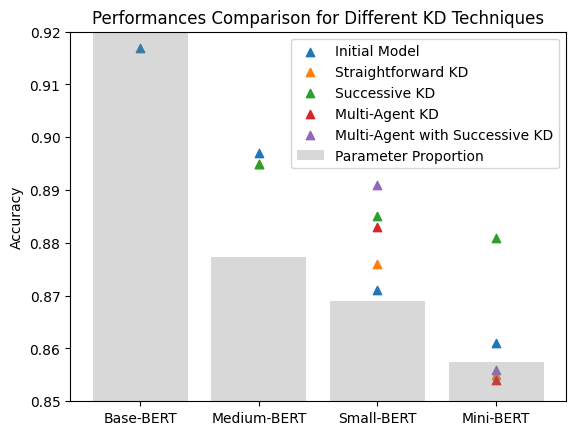

In [ ]:
for key in results.keys():
  plt.scatter([dico[i] for i in results[key]],results[key].values(),marker='^',label=key)
plt.bar([0,1,2,3],param_l,label='Parameter Proportion',alpha=0.3, color='grey')
plt.xticks([0,1,2,3],dico.keys())
plt.ylabel('Accuracy')
plt.ylim([0.85,0.92])
plt.title("Performances Comparison for Different KD Techniques")
plt.legend()

# Profiling

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from torch.profiler import profile, record_function, ProfilerActivity

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Profiling on CPU only.")

student_id = 'marlex7/successiveKD-Mini'

student_model = AutoModelForSequenceClassification.from_pretrained(
    student_id,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

student_model.to(device)

tokenizer_id = "google/bert_uncased_L-12_H-768_A-12"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)

input_text = "Random string to do profiling"

inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)

inputs = {k: v.to(device) for k, v in inputs.items()}

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            student_model(**inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))



```
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference        42.40%       3.725ms        99.84%       8.772ms       8.772ms       0.000us         0.00%       1.027ms       1.027ms             1  
                                           aten::linear         2.46%     216.000us        19.29%       1.695ms      65.192us       0.000us         0.00%     776.000us      29.846us            26  
                                            aten::addmm         9.54%     838.000us        13.89%       1.220ms      46.923us     776.000us        75.56%     776.000us      29.846us            26  
void sgemm_largek_lds64<true, false, 6, 3, 4, 5, 2, ...         0.00%       0.000us         0.00%       0.000us       0.000us     403.000us        39.24%     403.000us      50.375us             8  
void gemmSN_TN_kernel<float, 128, 16, 2, 4, 8, 9, fa...         0.00%       0.000us         0.00%       0.000us       0.000us     322.000us        31.35%     322.000us      16.100us            20  
                                       aten::layer_norm         0.49%      43.000us         5.10%     448.000us      49.778us       0.000us         0.00%      72.000us       8.000us             9  
                                aten::native_layer_norm         2.30%     202.000us         4.61%     405.000us      45.000us      72.000us         7.01%      72.000us       8.000us             9  
void at::native::(anonymous namespace)::vectorized_l...         0.00%       0.000us         0.00%       0.000us       0.000us      72.000us         7.01%      72.000us       8.000us             9  
                                           aten::matmul         1.29%     113.000us         6.43%     565.000us      70.625us       0.000us         0.00%      40.000us       5.000us             8  
                                              aten::bmm         2.36%     207.000us         3.14%     276.000us      34.500us      40.000us         3.89%      40.000us       5.000us             8  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
Self CPU time total: 8.786ms
Self CUDA time total: 1.027ms

```

